## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break


<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>
images shape on batch size = torch.Size([128, 1, 28, 28])
labels shape on batch size = torch.Size([128])


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [ ]:
torchsummary.summary(model.to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 392]         307,720
              ReLU-4                  [-1, 392]               0
            Linear-5                  [-1, 196]          77,028
              ReLU-6                  [-1, 196]               0
            Linear-7                   [-1, 10]           1,970
Total params: 386,718
Trainable params: 386,718
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.48
Estimated Total Size (MB): 1.50
----------------------------------------------------------------


Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()


In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
            opt.zero_grad()

            X_batch.to(device)
            y_batch.to(device)

            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                X_batch.to(device)
                y_batch.to(device)

                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)

                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

    return train_loss, val_loss, val_accuracy

In [ ]:
n_epochs = 25

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

In [ ]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

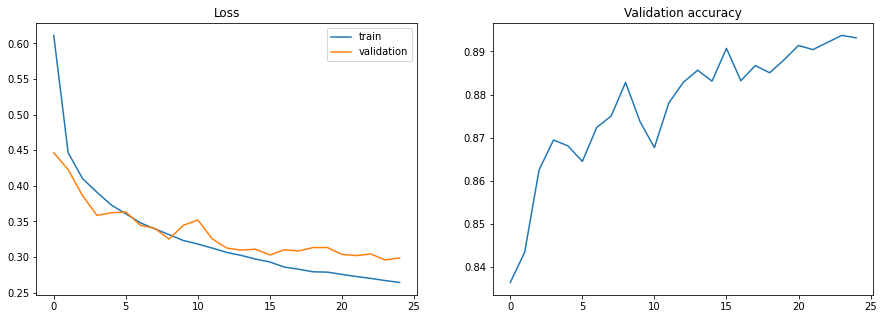

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
print("accuracy: ", val_accuracy[-1])

accuracy:  0.8931640625


Получилась точность, не ниже необходимой.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(784, 392),
            nn.ReLU(),
            nn.Linear(392, 10),
            nn.LogSoftmax()            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(OverfittingNeuralNetwork.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

Уменьшим датасет

In [ ]:
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [ ]:
val_size = 0.1
val_inds = subset_ind(fmnist_dataset_train, val_size)

train_dataset = Subset(fmnist_dataset_train, val_inds)

In [ ]:
len(train_dataset)

6000

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [ ]:
n_epochs = 75

train_loss, val_loss, val_accuracy = train_model(OverfittingNeuralNetwork, train_loader, test_loader, loss_func, opt, n_epochs)

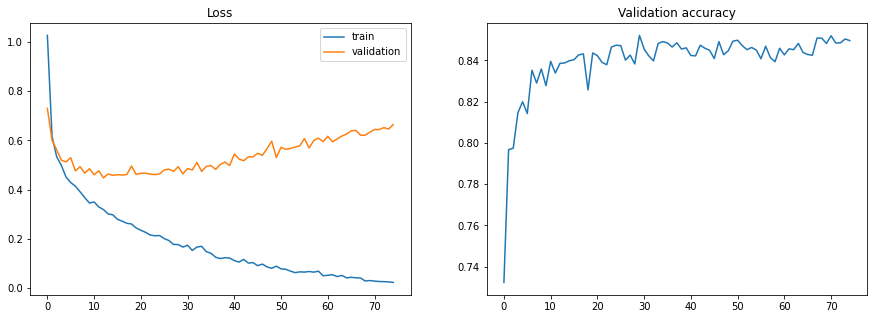

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

Как мы видим, что для train_data loss падает, а для valid_data loss растет - явный признак переобучения

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Dropout(p=0.5),
            nn.Linear(784, 392),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(392, 10),
            nn.LogSoftmax())
        
    def forward(self, inp):       
        out = self.model(inp)

Добавим в прерыдущую модель два Dropout, чтобы решить проблему с переобучением

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(FixedNeuralNetwork.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [ ]:
n_epochs = 75

train_loss, val_loss, val_accuracy = train_model(TopModel, train_loader, test_loader, loss_func, opt, n_epochs)

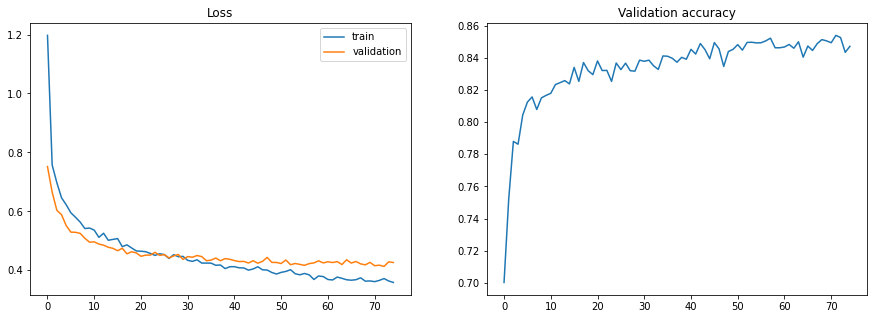

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Conclusions:
Как видно из графиков, при использование техник регуляризации модель переобучается меньше. Это видно, если сравнить два loss графика. Для модели, которая переобучилась, кривые, описывающие loss для train и val data расходятся. Модель переобучалась из-за того, что была маленькая обучающая выборка, я ее намеренно уменьшила до 6к, а параметром было >300к. Поэтому модель запоминала данные => переобучалась. После того как я в модель добавила dropout, результат улучшился и разрыв в loss между train и val data стал не настолько критичным.